# Node Classification using Graph Convolutional Network on Biomedical Knowledge Graph (KG)

In this project, I will investigate the task of classifying different types of entities in a biomedical knowledge graph (KG), which usually contains entities for `disease`, `drug`, `gene`, etc. Specifically, we will work on the Hetionet KG [link](https://het.io/). Hetionet is on the smaller size, containing ~2 million triples (head, relation, tail) compared to other biomedical KGs. 

I will also be exploring the use of **Graph Convolutional Network** (GCN) and the Deep Graph Library [DGL](https://www.dgl.ai/). Previous work has shown GCN works very well in node classification task, specifically DGL has shown robust performance on the Cora Citation dataset [link](https://docs.dgl.ai/en/0.6.x/tutorials/blitz/1_introduction.html). It is worth noting that the default Cora dataset contains an already-generated feature matrix, each feature is a vocabulary word and its count in the publication. For our Hetionet dataset, there is no feature matrix that has been generated. Therefore, in this work, I will see how well the GCN network is able to classify nodes into different types as well as investigate the importance of feature engineering. 

In [2]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE
from sklearn.metrics import f1_score, accuracy_score
from pykeen.datasets import Hetionet
from node2vec import Node2Vec
import networkx as nx
import pandas as pd
import numpy as np
import os
import torch
from torch import Tensor, nn
from torch import nn
import torch.nn as nn
import torch.nn.functional as F
import dgl
from dgl.nn.pytorch import GraphConv
from typing import Optional, Sequence
import warnings
warnings.filterwarnings("ignore")

Using backend: pytorch


## Dataset: Hetionet
Let's first look at the biomedical knowledge graph dataset `Hetionet`. The dataset is available online, but I have downloaded it through `PyKEEN`, which is a python module that helps perform a lot of embedding-based tasks with knowledge graphs and have published extensively on its performance on different benchmark datasets, including Hetionet.

PyKEEN does divide the triples into the training, testing, and validation datasets for us already. However, this is specifically for link prediction tasks in which we are interested in the relations. In this current task, we are interested in classifying the nodes, so I will merge their pre-divided training, testing and validation sets.

The `meta_edge` dictionary below is copied from the Hetionet documentation [link](https://het.io/explore/). Based on the documentation, I have processed the head, relation and tail to create the `head_class`, `tail_class` and `edge_class` columns.

In [2]:
meta_edge = {
				'AdG': 'Anatomy-downregulates-Gene',
				'AeG': 'Anatomy-expresses-Gene',
				'AuG': 'Anatomy-upregulates-Gene',
				'CbG': 'Compound-binds-Gene',
				'CcSE': 'Compound-causes-Side Effect',
				'CdG': 'Compound-downregulates-Gene',
				'CpD': 'Compound-palliates-Disease',
				'CrC': 'Compound-resembles-Compound',
				'CtD': 'Compound-treats-Disease',
				'CuG': 'Compound-upregulates-Gene',
				'DaG': 'Disease-associates-Gene',
				'DdG': 'Disease-downregulates-Gene',
				'DlA': 'Disease-localizes-Anatomy',
				'DpS': 'Disease-presents-Symptom',
				'DrD': 'Disease-resembles-Disease',
				'DuG': 'Disease-upregulates-Gene',
				'GcG': 'Gene-covaries-Gene',
				'GiG': 'Gene-interacts-Gene',
				'GpBP': 'Gene-participates-Biological Process',
				'GpCC': 'Gene-participates-Cellular Component',
				'GpMF': 'Gene-participates-Molecular Function',
				'GpPW': 'Gene-participates-Pathway',
				'Gr>G': 'Gene-regulates-Gene',
				'PCiC': 'Pharmacologic Class-includes-Compound',
			}

data = Hetionet(create_inverse_triples=False, random_state=357)
training = data.training
validation = data.validation
testing = data.testing

training_df = training.tensor_to_df(training.mapped_triples)[['head_label', 'relation_label', 'tail_label']]
training_df = training_df.rename(columns={'head_label': 'head', 'relation_label': 'edge', 'tail_label': 'tail'})
validation_df = validation.tensor_to_df(validation.mapped_triples)[['head_label', 'relation_label', 'tail_label']]
validation_df = validation_df.rename(columns={'head_label': 'head', 'relation_label': 'edge', 'tail_label': 'tail'})
testing_df = testing.tensor_to_df(testing.mapped_triples)[['head_label', 'relation_label', 'tail_label']]
testing_df = testing_df.rename(columns={'head_label': 'head', 'relation_label': 'edge', 'tail_label': 'tail'})

data_df = pd.concat([training_df, validation_df, testing_df])
data_df['edge_class'] = data_df['edge'].map(meta_edge)
data_df['head_class'] = data_df['edge_class'].str.split('-').apply(lambda x: x[0])
data_df['tail_class'] = data_df['edge_class'].str.split('-').apply(lambda x: x[-1])

Let's explore this dataset to see what entities we have available.

In [3]:
data_df.head()

,head,edge,tail,edge_class,head_class,tail_class
0,Anatomy::UBERON:0000002,AdG,Gene::10005,Anatomy-downregulates-Gene,Anatomy,Gene
1,Anatomy::UBERON:0000002,AdG,Gene::114804,Anatomy-downregulates-Gene,Anatomy,Gene
2,Anatomy::UBERON:0000002,AdG,Gene::118670,Anatomy-downregulates-Gene,Anatomy,Gene
3,Anatomy::UBERON:0000002,AdG,Gene::128989,Anatomy-downregulates-Gene,Anatomy,Gene
4,Anatomy::UBERON:0000002,AdG,Gene::132851,Anatomy-downregulates-Gene,Anatomy,Gene


In [4]:
set(data_df['head_class'].unique().tolist() + data_df['tail_class'].unique().tolist())

{'Anatomy',
 'Biological Process',
 'Cellular Component',
 'Compound',
 'Disease',
 'Gene',
 'Molecular Function',
 'Pathway',
 'Pharmacologic Class',
 'Side Effect',
 'Symptom'}

In [5]:
h = data_df[['head', 'head_class']].rename(columns={'head': 'entity', 'head_class': 'entity_class'})
t = data_df[['tail', 'tail_class']].rename(columns={'tail': 'entity', 'tail_class': 'entity_class'})
h_t = pd.concat((h,t)).drop_duplicates()
h_t['entity_class'].value_counts()

Gene                   19145
Biological Process     11381
Side Effect             5701
Molecular Function      2884
Pathway                 1822
Compound                1538
Cellular Component      1391
Symptom                  415
Anatomy                  400
Pharmacologic Class      345
Disease                  136
Name: entity_class, dtype: int64

Looks like we have 11 entities classes, but the entity `gene` is extremely abundant, whereas there are some entities with very few nodes, such as `disease` and `pharmacologic class`.

This kind of unbalanced dataset will impact the result of our classification. One solution to reduce the influence of unbalanced data is using **Focal Loss** instead of normal cross entropy loss. Focal Loss more heavily penalizes training points that are more rare (e.g. disease) compared to abundant training examples (gene).

In [3]:
# Taken from https://stackoverflow.com/questions/31517194/how-to-hide-one-specific-cell-input-or-output-in-ipython-notebook
from IPython.display import HTML, display
tag = HTML('''<script>
code_show=true; 
function code_toggle() {
    if (code_show){
        $('div.cell.code_cell.rendered.selected div.input').hide();
    } else {
        $('div.cell.code_cell.rendered.selected div.input').show();
    }
    code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The focal loss code is taken from AdeelH's github (https://github.com/AdeelH/pytorch-multi-class-focal-loss).

To show/hide this cell's raw Focal Loss code input, click <a href="javascript:code_toggle()">here</a>.''')
display(tag)

############### Write code below ##################

class FocalLoss(nn.Module):
    def __init__(self,
                 alpha: Optional[Tensor] = None,
                 gamma: float = 0.,
                 reduction: str = 'mean',
                 ignore_index: int = -100):
        if reduction not in ('mean', 'sum', 'none'):
            raise ValueError(
                'Reduction must be one of: "mean", "sum", "none".')
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.ignore_index = ignore_index
        self.reduction = reduction
        self.nll_loss = nn.NLLLoss(
            weight=alpha, reduction='none', ignore_index=ignore_index)

    def __repr__(self):
        arg_keys = ['alpha', 'gamma', 'ignore_index', 'reduction']
        arg_vals = [self.__dict__[k] for k in arg_keys]
        arg_strs = [f'{k}={v}' for k, v in zip(arg_keys, arg_vals)]
        arg_str = ', '.join(arg_strs)
        return f'{type(self).__name__}({arg_str})'

    def forward(self, x: Tensor, y: Tensor) -> Tensor:
        if x.ndim > 2:
            c = x.shape[1]
            x = x.permute(0, *range(2, x.ndim), 1).reshape(-1, c)
            y = y.view(-1)

        unignored_mask = y != self.ignore_index
        y = y[unignored_mask]
        if len(y) == 0:
            return 0.
        x = x[unignored_mask]

        log_p = F.log_softmax(x, dim=-1)
        ce = self.nll_loss(log_p, y)

        all_rows = torch.arange(len(x))
        log_pt = log_p[all_rows, y]

        pt = log_pt.exp()
        focal_term = (1 - pt)**self.gamma

        loss = focal_term * ce

        if self.reduction == 'mean':
            loss = loss.mean()
        elif self.reduction == 'sum':
            loss = loss.sum()
        return loss

def focal_loss(alpha: Optional[Sequence] = None, gamma: float = 0., reduction: str = 'mean', ignore_index: int = -100, device='cpu', dtype=torch.float32) -> FocalLoss:
    if alpha is not None:
        if not isinstance(alpha, Tensor):
            alpha = torch.tensor(alpha)
        alpha = alpha.to(device=device, dtype=dtype)
    fl = FocalLoss(alpha=alpha, gamma=gamma, reduction=reduction, ignore_index=ignore_index)
    return fl

In [7]:
from IPython.display import HTML
from IPython.display import display

## Create Graph
I will now create a directed NetworkX graph `G_nx` from our Hetionet data. I created the `labels_map` dictionary manually for my own reference. Each node cantains the `label` (entity type) and `label_id` (id from `labels_map`) for debugging purposes as well. I will not display this NetworkX graph since it is still extremely large (2M connections).

One thing to note is that the nodes in `G_nx` are ordered. I will be using this order for creating the features and labels for our training.

In [8]:
labels_map = {
				'Anatomy': 0,
				'Biological Process': 1,
				'Cellular Component': 2,
				'Compound': 3,
				'Disease': 4,
				'Gene': 5,
				'Molecular Function': 6,
				'Pathway': 7,
				'Pharmacologic Class': 8,
				'Side Effect': 9,
				'Symptom': 10,
			}

G_nx = nx.DiGraph() # directed
for edge in data_df['edge'].unique():
	G_nx.add_edges_from(list(data_df.loc[data_df['edge']==edge, ['head','tail']].to_records(index=False)), label=edge)
all_nodes = list(G_nx.nodes)	
for node in all_nodes:
	label = node.split('::')[0]
	G_nx.nodes[node]['label'] = label
	G_nx.nodes[node]['label_id'] = labels_map[label]

In [9]:
# mask
training_nodes, testing_nodes = train_test_split(all_nodes, test_size=0.2, random_state=100)
training_nodes, validation_nodes = train_test_split(training_nodes, test_size=0.2, random_state=101)
training_mask = torch.tensor([True if n in training_nodes else False for n in all_nodes])
testing_mask = torch.tensor([True if n in testing_nodes else False for n in all_nodes])
validation_mask = torch.tensor([True if n in validation_nodes else False for n in all_nodes])

# labels
labels = torch.tensor([G_nx.nodes[n]['label_id'] for n in all_nodes])

## Feature Engineering
There are multiple ways we can engineer features for our graph. Here are a few ways I will try:
1. Random
2. Identity Matrix
3. Adjacency Matrix
4. Node2Vec
5. Hand-crafted

### 1. Random Features

In [10]:
n_features = 1000
features_np = np.random.rand(len(all_nodes), n_features)
features = torch.tensor(features_np).float()
all_features = {'random': features}

### 2. Identity Matrix

In [11]:
n_features = len(all_nodes)
features_np = np.eye(n_features)
features = torch.tensor(features_np).float()
all_features['identity'] = features

### 3. Adjacency Matrix

In [12]:
n_features = len(all_nodes)
features_np = nx.adjacency_matrix(G_nx, nodelist=G_nx.nodes()).toarray() # adjacency matrix
features = torch.tensor(features_np).float()
all_features['adj_matrix'] = features

### 4. Node2Vec
This `node2vec` algorithm learns low-dimensional representation of each node (node embedding) by simulating random walk. We start off by encoding the nodes with integer numbers, then we perform random walk from the starting node to generate a 'walk' sequence, which would contain useful information about the neighbors of that starting node. Node2Vec is a type of biased random walk since it specifies 2 separate probabilities, `p` which is the probability to return to the previous node, and `q` which is the probability of staying in the neighborhood of the starting node -- a high `q` would mean we are performing breadth-first search from the first node. Node2Vec has been used to create node embeddings for many types of downstream tasks on knowledge graphs. More information can be found [here](https://snap.stanford.edu/node2vec/).

In [13]:
already_generated = True

n_features = 1000
random_walk_length = 100
random_walk_num = 100
random_walk_dimensions = n_features

if not already_generated:
	model_n2v = Node2Vec(G_nx, dimensions=random_walk_dimensions, walk_length=random_walk_length, num_walks=random_walk_num).fit(window=10, min_count=1)
	features_np = model_n2v.wv.vectors
	features = torch.tensor(features_np)
	scaler = MinMaxScaler()
	features = torch.tensor(scaler.fit_transform(features)).float()
	torch.save(features, 'features_node2vec.pt')
else:
	features = torch.load('features_node2vec.pt')
    
all_features['node2vec'] = features

### 5. Hand-crafted
For the last one, I will hand-craft a few features for each node. Some of these features are derived from this blog post [link](https://towardsdatascience.com/deepgl-on-neo4j-b27e8c64190f). The features include the node's in-degree, out-degree as well as its neighbors distribution of in- and out-degrees.

In [14]:
already_generated = True

if not already_generated:
	agg_functions = [np.sum, np.max, np.mean, np.linalg.norm, np.prod]
	all_nodes_features = []
	for node in all_nodes:
		node_features 	= []
		node_in_degree 	= G_nx.in_degree(node)
		node_features.append(node_in_degree)
		node_out_degree = G_nx.out_degree(node)
		node_features.append(node_out_degree)
		node_degree 	= G_nx.degree(node)
		node_features.append(node_degree)

		in_neighbors 	= [nbr for nbr in G_nx.predecessors(node)]
		in_neighbors_in_degree = []
		in_neighbors_out_degree = []
		in_neighbors_degree = []
		for nbr in in_neighbors:
			nbr_in_degree 	= G_nx.in_degree(nbr)
			in_neighbors_in_degree.append(nbr_in_degree)
			nbr_out_degree 	= G_nx.out_degree(nbr)
			in_neighbors_out_degree.append(nbr_out_degree)
			nbr_degree 		= G_nx.degree(nbr)
			in_neighbors_degree.append(nbr_degree)
		for func in agg_functions:
			if len(in_neighbors_in_degree) > 0:
				nbr_in_degree_func = func(in_neighbors_in_degree)
			else: nbr_in_degree_func = 0
			node_features.append(nbr_in_degree_func)
			if len(in_neighbors_out_degree) > 0:
				nbr_out_degree_func = func(in_neighbors_out_degree)
			else: nbr_out_degree_func = 0
			node_features.append(nbr_out_degree_func)
			if len(in_neighbors_degree) > 0:
				nbr_degree_func = func(in_neighbors_degree)
			else: nbr_degree_func = 0
			node_features.append(nbr_degree_func)

		out_neighbors = G_nx[node]
		out_neighbors_in_degree = []
		out_neighbors_out_degree = []
		out_neighbors_degree = []
		for nbr in out_neighbors:
			nbr_in_degree 	= G_nx.in_degree(nbr)
			out_neighbors_in_degree.append(nbr_in_degree)
			nbr_out_degree 	= G_nx.out_degree(nbr)
			out_neighbors_out_degree.append(nbr_out_degree)
			nbr_degree 		= G_nx.degree(nbr)
			out_neighbors_degree.append(nbr_degree)
		for func in agg_functions:
			if len(out_neighbors_in_degree) > 0:
				nbr_in_degree_func = func(out_neighbors_in_degree)
			else: nbr_in_degree_func = 0
			node_features.append(nbr_in_degree_func)
			if len(out_neighbors_out_degree) > 0:
				nbr_out_degree_func = func(out_neighbors_out_degree)
			else: nbr_out_degree_func = 0
			node_features.append(nbr_out_degree_func)
			if len(out_neighbors_degree) > 0:
				nbr_degree_func = func(out_neighbors_degree)
			else: nbr_degree_func = 0
			node_features.append(nbr_degree_func)

		all_nodes_features.append(node_features)
	n_features = len(all_nodes_features[0])
	features_np = np.array(all_nodes_features)

	features = torch.tensor(features_np)
	scaler = MinMaxScaler()
	features = torch.tensor(scaler.fit_transform(features)).float()
	torch.save(features, 'features_engineered.pt')

else:
	features = torch.load('features_engineered.pt')
	n_features = features.shape[1]
    
all_features['engineered'] = features

Now that we have created our different features, let's see if we can visualize some of the features and predict if our GCN will be successful in classifying the nodes. Below, I show the tSNE features for the hand-crafted (first) and node2vec (second) features. From both plots, we expect that the hand-crafted features will at least be able to distinguish between class 5 (gene) better, whereas the node2vec do not seem to show bigger distinct clusters. These graphs demonstrate the difficulty of the classification task for Hetionet.

ENGINEERED FEATURES


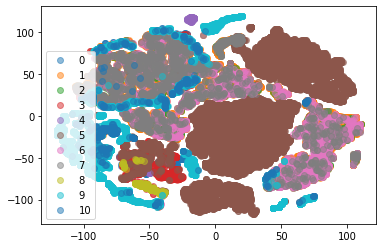

In [15]:
print('ENGINEERED FEATURES')
features_tsne = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(all_features['engineered'].detach().numpy())
for l in range(11):
	plt.scatter(features_tsne[labels==l,0], features_tsne[labels==l,1], alpha=0.5)
plt.legend(list(range(len(labels_map))))
plt.show()

NODE2VEC FEATURES


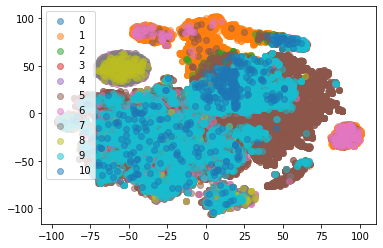

In [16]:
print('NODE2VEC FEATURES')
features_tsne = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(all_features['node2vec'].detach().numpy())
for l in range(11):
	plt.scatter(features_tsne[labels==l,0], features_tsne[labels==l,1], alpha=0.5)
plt.legend(list(range(len(labels_map))))
plt.show()

# Graph Convolutional Network
I will now use the DGL library to train a 2-layer GCN, with 16 hidden features in the middle layer.

One thing to note is that the the focal loss, we need to set the `gamma` and `alpha` parameters. The focal loss is defined as $FL(p) = -\alpha(1-p)^{\gamma}log(p)$, so `gamma` alters the proability of the class and `alpha` is the weight of each class. In this project, we will set `gamma=50` and `alpha` as the normalized inverse probability that a node belongs to a particular class.

In [17]:
G_dgl = dgl.from_networkx(G_nx)
G_dgl = dgl.add_self_loop(G_dgl)

class GCN(nn.Module):
    def __init__(self, in_feats, h_feats, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GraphConv(in_feats, h_feats)
        self.conv2 = GraphConv(h_feats, num_classes)

    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        h = self.conv2(g, h)
        return h

In [18]:
def train(features_by, n_epochs=200):
    # features_by: random, identity, adj_matrix, node2vec, engineered
    features = all_features[features_by]
    n_features = features.shape[1]
    
    model, focal_loss, logits, loss = None, None, None, None # clear vars
    
    model = GCN(n_features, 16, len(labels_map))
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    # n_epochs = 200
    training_accuracies = []
    validation_accuracies = []
    validation_f1s = []
    
    alpha = torch.tensor(pd.Series(labels).value_counts(normalize=True)[list(range(11))].tolist()).float()
    alpha = 1 / alpha
    alpha /= alpha.sum()
    focal_loss = FocalLoss(gamma=50, alpha=alpha)

    for epoch in range(n_epochs):
        logits = model(G_dgl, features)
        pred = logits.argmax(1)
        loss = focal_loss(logits[training_mask], labels[training_mask]) # instead of cross entropy loss

        training_accuracy = (pred[training_mask] == labels[training_mask]).float().mean()
        training_accuracies.append(training_accuracy)
        validation_accuracy = (pred[validation_mask] == labels[validation_mask]).float().mean()
        validation_accuracies.append(validation_accuracy)
        validation_f1 = f1_score(pred[validation_mask], labels[validation_mask], average='macro')
        validation_f1s.append(validation_f1)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

#         if epoch % 10 == 0:
#             print('Epoch {}, Train_Acc {}, Valid_Acc {}, Valid_F1 {}'.format(epoch, round(training_accuracy.item(),3), round(validation_accuracy.item(),3), round(validation_f1,3)))
    return model, validation_f1s

In [19]:
def test(features_by, model):
    features = all_features[features_by]
    n_features = features.shape[1]
    
    model.eval()
    with torch.no_grad():
        logits = model(G_dgl, features)
        pred = logits.argmax(1)
        pred_testing = pred[testing_mask]
        labels_testing = labels[testing_mask]
        testing_accuracy = (pred_testing == labels_testing).float().mean()

        testing_f1 = f1_score(pred_testing, labels_testing, average=None)
    return testing_f1

### 1. Random
It looks like random can only achieve a very low average F1 score across different clases. We already know that random features is probably not a good way to classify nodes, but at least this establishes a baseline for our other feature engineering methods.

In [20]:
features_by = 'random'
n_epochs = 200
model, validation_f1s = train(features_by, n_epochs)
testing_f1 = test(features_by, model)
pd.DataFrame(zip(list(labels_map.keys()), testing_f1), columns=['Class', 'F1']).append({'Class':'Mean', 'F1':testing_f1.mean()}, ignore_index=True)

,Class,F1
0,Anatomy,0.000000
1,Biological Process,0.000000
2,Cellular Component,0.000000
3,Compound,0.000000
4,Disease,0.000000
5,Gene,0.000000
6,Molecular Function,0.000000
7,Pathway,0.000000
8,Pharmacologic Class,0.000000
9,Side Effect,0.000000


### 2. Identity Matrix
Using the identity matrix, which is a method frequently used in GCN for graphs that do not have any extracted features, seems to only perform reasonably for common classes, such as the gene entity. After 50 epochs, the F1 score seems to be leveling out, but the pattern does not follow the exponential decay trend.

In [21]:
features_by = 'identity'
n_epochs = 50
model, validation_f1s = train(features_by, n_epochs)
testing_f1 = test(features_by, model)
pd.DataFrame(zip(list(labels_map.keys()), testing_f1), columns=['Class', 'F1']).append({'Class':'Mean', 'F1':testing_f1.mean()}, ignore_index=True)

,Class,F1
0,Anatomy,0.042705
1,Biological Process,0.186169
2,Cellular Component,0.055866
3,Compound,0.000000
4,Disease,0.024096
5,Gene,0.475482
6,Molecular Function,0.049635
7,Pathway,0.000000
8,Pharmacologic Class,0.000000
9,Side Effect,0.024958


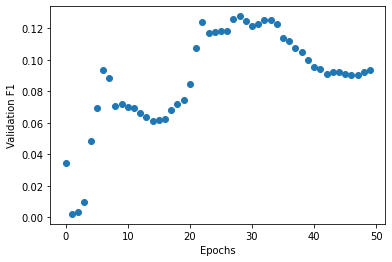

In [22]:
plt.scatter(list(range(n_epochs)), validation_f1s)
plt.xlabel('Epochs')
plt.ylabel('Validation F1')
plt.show()

### 3. Adjacency Matrix
Using the adjacency matrix seems to perform better than the identity matrix features, with the mean F1 in the validation set plateauing around 0.20. The adjacency matrix features are also able to classify nodes that are not of the most common classes, even though the F1 score for these classes are still very low.

In [23]:
features_by = 'adj_matrix'
n_epochs = 150
model, validation_f1s = train(features_by, n_epochs)
testing_f1 = test(features_by, model)
pd.DataFrame(zip(list(labels_map.keys()), testing_f1), columns=['Class', 'F1']).append({'Class':'Mean', 'F1':testing_f1.mean()}, ignore_index=True)

,Class,F1
0,Anatomy,0.051813
1,Biological Process,0.350998
2,Cellular Component,0.108738
3,Compound,0.137374
4,Disease,0.040100
5,Gene,0.502722
6,Molecular Function,0.482196
7,Pathway,0.245478
8,Pharmacologic Class,0.517857
9,Side Effect,0.286115


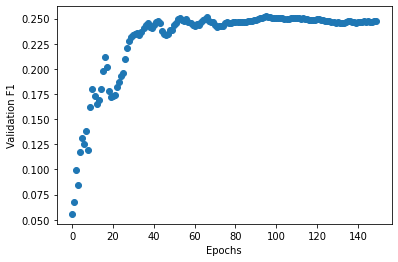

In [24]:
plt.scatter(list(range(n_epochs)), validation_f1s)
plt.xlabel('Epochs')
plt.ylabel('Validation F1')
plt.show()

### 4. Node2Vec
The node2vec features do not perform well at all. Even though there seems to be a spike in the middle epochs, but even at the peak F1 validation score, the F1 score is still much lower compared to the validation score using the adjacency matrix. 

In [25]:
features_by = 'node2vec'
n_epochs = 200
model, validation_f1s = train(features_by, n_epochs)
testing_f1 = test(features_by, model)
pd.DataFrame(zip(list(labels_map.keys()), testing_f1), columns=['Class', 'F1']).append({'Class':'Mean', 'F1':testing_f1.mean()}, ignore_index=True)

,Class,F1
0,Anatomy,0.000000
1,Biological Process,0.000000
2,Cellular Component,0.000000
3,Compound,0.000000
4,Disease,0.000000
5,Gene,0.000000
6,Molecular Function,0.000000
7,Pathway,0.000000
8,Pharmacologic Class,0.000000
9,Side Effect,0.000000


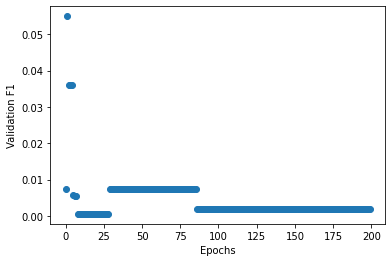

In [26]:
plt.scatter(list(range(n_epochs)), validation_f1s)
plt.xlabel('Epochs')
plt.ylabel('Validation F1')
plt.show()

### 5. Engineered Features
Lastly, the hand-crafted engineered features also perform very well, even though it is still slightly lower compared to using the adjacency matrix as features. The advantage to using our hand-crafted features is that there are only 33 features to consider, compared to the adjacency matrix in which `num_features=num_nodes`, which is very large even for our Hetionet graph. Therefore, even though there is a lower performance for using our engineered features, it is still much faster to train compared to using the adjacency matrix. Additionally, there are many more features that can be extracted, more of which can be found in this [paper](https://arxiv.org/pdf/1704.08829.pdf).

In [27]:
features_by = 'engineered'
n_epochs = 150
model, validation_f1s = train(features_by, n_epochs)
testing_f1 = test(features_by, model)
pd.DataFrame(zip(list(labels_map.keys()), testing_f1), columns=['Class', 'F1']).append({'Class':'Mean', 'F1':testing_f1.mean()}, ignore_index=True)

,Class,F1
0,Anatomy,0.027907
1,Biological Process,0.369803
2,Cellular Component,0.055556
3,Compound,0.103757
4,Disease,0.015228
5,Gene,0.331746
6,Molecular Function,0.282969
7,Pathway,0.214403
8,Pharmacologic Class,0.071264
9,Side Effect,0.023603


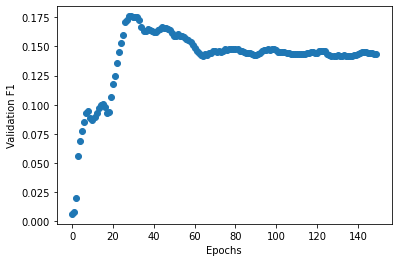

In [28]:
plt.scatter(list(range(n_epochs)), validation_f1s)
plt.xlabel('Epochs')
plt.ylabel('Validation F1')
plt.show()

# Logistic Regression
To test how robust GCN performed and remove the influence of feature engineering, I will perform node classification using these same features with a simple out-of-the-box logistic regressor. We can see that the features that performed relatively well (hand-crafted, node2vec and adjacency matrix) all performed very well with logistic regression, with the exception of a few classes that just cannot be separated with a linear regressor. These classes were able to be classified with GCN using the adjacency matrix and the engineered hand-crafted features (see the class-wise F1 scores), but as a result the performance of the other classes suffered. It would depend on the use case, whether we choose to optimize the overall performance or whether we want to improve the performance of these rare classes, to decide which classifier to use.

### Engineered Features

In [29]:
features_by = 'engineered'

features = all_features[features_by]
lr = LogisticRegression(random_state=0).fit(features[training_mask], labels[training_mask])
lr_preds = lr.predict(features)
f1_lr = f1_score(lr_preds[testing_mask], labels[testing_mask], average=None)
pd.DataFrame(zip(list(labels_map.keys()), f1_lr), columns=['Class', 'F1']).append({'Class':'Mean', 'F1':f1_lr.mean()}, ignore_index=True)

,Class,F1
0,Anatomy,0.361905
1,Biological Process,0.779976
2,Cellular Component,0.000000
3,Compound,0.823718
4,Disease,0.885246
5,Gene,0.986180
6,Molecular Function,0.000000
7,Pathway,0.000000
8,Pharmacologic Class,0.000000
9,Side Effect,0.872243


### Node2Vec Features

In [30]:
features_by = 'node2vec'

features = all_features[features_by]
lr = LogisticRegression(random_state=0).fit(features[training_mask], labels[training_mask])
lr_preds = lr.predict(features)
f1_lr = f1_score(lr_preds[testing_mask], labels[testing_mask], average=None)
pd.DataFrame(zip(list(labels_map.keys()), f1_lr), columns=['Class', 'F1']).append({'Class':'Mean', 'F1':f1_lr.mean()}, ignore_index=True)

,Class,F1
0,Anatomy,0.000000
1,Biological Process,0.648101
2,Cellular Component,0.000000
3,Compound,0.000000
4,Disease,0.000000
5,Gene,0.750883
6,Molecular Function,0.032164
7,Pathway,0.010870
8,Pharmacologic Class,0.000000
9,Side Effect,0.018597


### Adjacency Matrix Features

In [31]:
features_by = 'adj_matrix'

features = all_features[features_by]
lr = LogisticRegression(random_state=0).fit(features[training_mask], labels[training_mask])
lr_preds = lr.predict(features)
f1_lr = f1_score(lr_preds[testing_mask], labels[testing_mask], average=None)
pd.DataFrame(zip(list(labels_map.keys()), f1_lr), columns=['Class', 'F1']).append({'Class':'Mean', 'F1':f1_lr.mean()}, ignore_index=True)

,Class,F1
0,Anatomy,0.635659
1,Biological Process,0.598701
2,Cellular Component,0.000000
3,Compound,0.924071
4,Disease,0.740741
5,Gene,0.928612
6,Molecular Function,0.000000
7,Pathway,0.000000
8,Pharmacologic Class,0.142857
9,Side Effect,0.000000


# Conclusion
In this project, we have demonstrated the use of a Graph Convolutional Network to perform node classification for a biomedical knowledge graph Hetionet. This work emphasizes the importance of feature engineering as well as the ability of GCN to classify nodes with features that are not linearly separable, as demonstrated by the difference in performance compared to logistic regression.

Node classification is a smaller use case in biomedical knowledge graph. In most applications, we would already know the type of entity for the node of interest. What we would not know is whether this node is connected to other nodes with a specific type of relation -- this is the link prediction task which is an active area of research.